In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import sys
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from numpy.random import randn
from scipy.io import loadmat
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model,Sequential,Model
import math
import time
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Lambda,Concatenate,Dropout
import pdb; 
import scipy
from keras.constraints import Constraint
from scipy.stats import truncnorm

In [2]:
#Data Preprocessing Functions

'''
#This is the function to format the generators' cost
'''
'''
#This is the function to format the generators' cost
'''
def get_gencost(number_of_buses,mat_gen,mat_gencost):
  gen_ids = mat_gen[:,0]-1
  c1=np.zeros(number_of_buses)
  c2=np.zeros(number_of_buses)
  j=0
  for i in range(0,number_of_buses):
    if i in gen_ids:
      c1[i] = mat_gencost[j,5]
      c2[i] = mat_gencost[j,4]
      j=j+1
  tf_c1 = tf.convert_to_tensor(c1,dtype='float32')
  tf_c2 = tf.convert_to_tensor(c2,dtype='float32')
  return tf_c1,tf_c2

'''
#This is the function to get and format the upper and lower bound 
#of active&reactive power at each buse
'''
def get_pq_bound(number_of_buses, mat_gen):
  number_of_gens = mat_gen.shape[0]
  p_upper = np.zeros(number_of_buses)
  q_upper = np.zeros(number_of_buses)
  q_lower = np.zeros(number_of_buses)
  j=0
  for i in range(0,number_of_buses):
    if i in (mat_gen[:,0]-1):
      #pdb.set_trace()
      p_upper[i]=mat_gen[j,8]
      q_upper[i]=mat_gen[j,3]
      q_lower[i]=mat_gen[j,4]
      j=j+1
  tf_p_upper = tf.convert_to_tensor(p_upper/baseMVA,dtype='float32')
  tf_q_upper = tf.convert_to_tensor(q_upper/baseMVA,dtype='float32')
  tf_q_lower = tf.convert_to_tensor(q_lower/baseMVA,dtype='float32')
  return tf_p_upper,tf_q_upper,tf_q_lower

'''
#This is the function to get and format the upper and lower bound 
#of voltage magnitude&angle at each buse
'''
def get_vm_va_bound(mat_load):
  vm_lower = mat_load['aa'][:,-1]
  vm_upper = mat_load['aa'][:,-2]
  vm_lower[0]=1
  vm_upper[0]=1
  va_lower = np.ones(118)*(-180)
  va_upper = np.ones(118)*(180)
  va_lower[0]=0
  va_upper[0]=0
  tf_vm_upper = tf.convert_to_tensor(vm_upper,dtype='float32')
  tf_vm_lower = tf.convert_to_tensor(vm_lower,dtype='float32')
  tf_va_upper = tf.convert_to_tensor(va_upper,dtype='float32')
  tf_va_lower = tf.convert_to_tensor(va_lower,dtype='float32')
  return tf_vm_upper,tf_vm_lower,tf_va_upper,tf_va_lower

In [3]:
'''
#This is the block to load data from matlab, and cvs dataset
#Then process them ready for the neural network training
'''
#Load grid data from matlab
mat_y = loadmat('/content/drive/MyDrive/Phd/opf_gan/Y_bus118.mat')
mat_gen = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE118_gen.mat')['gen118']
mat_load = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE118_load.mat')
#mat_gencost = pd.read_csv('new_cost.csv').values[:,1:]
mat_gencost = loadmat('/content/drive/MyDrive/Phd/opf_gan/case118_gencost.mat')['gencost']

#Load dataset
condition_part1 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_condition_25674.mat')['conditions_list']
solution_part1 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_points_25674.mat')['datapoints_list']
condition_part2 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_condition_442.mat')['conditions_list']
solution_part2 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_points_442.mat')['datapoints_list']
condition_part3 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_condition_380.mat')['conditions_list']
solution_part3 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_points_380.mat')['datapoints_list']
#condition_part4 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_condition_14458.mat')['conditions_list']
#solution_part4 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_points_14458.mat')['datapoints_list']
#condition_part5 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_condition_314.mat')['conditions_list']
#solution_part5 = loadmat('/content/drive/MyDrive/Phd/opf_gan/new_case118_feasible_points_314.mat',squeeze_me=False)['datapoints_list']

opf_condition = loadmat('/content/drive/MyDrive/Phd/opf_gan/case118_opf_condition_19796.mat')['conditions_list']
opf_points = loadmat('/content/drive/MyDrive/Phd/opf_gan/case118_opf_condition_19796.mat')['conditions_list']
#Data preprocessing
Y_bus = mat_y['Y_bus118'].toarray().astype('complex64')
baseMVA = 100
case118_pload = mat_load['aa'][:,2]/baseMVA
case118_qload = mat_load['aa'][:,3]/baseMVA
real_conditions = np.concatenate([condition_part1,condition_part2,condition_part3],axis=0)/baseMVA
real_points = np.concatenate([solution_part1,solution_part2,solution_part3],axis=0)
real_vm = real_points[:,0:118]
real_va = real_points[:,118:236]
matpower_p = real_points[:,236:290]
matpower_q = real_points[:,290:]
real_p = np.zeros(real_vm.shape)
real_q = np.zeros(real_vm.shape)
gen_ids = mat_gen[:,0]-1
j=0
for i in range(0,118):
  if i in gen_ids:
    real_p[:,i]=matpower_p[:,j]
    real_q[:,i]=matpower_q[:,j]
    j=j+1
real_p=real_p/baseMVA
real_q = real_q/baseMVA
opf_real_conditions = opf_condition[0:6000,:]/baseMVA

opf_training_conditions = opf_condition[6000:6100,:]/baseMVA

tf_p_upper,tf_q_upper,tf_q_lower = get_pq_bound(118, mat_gen)
tf_vm_upper,tf_vm_lower,tf_va_upper,tf_va_lower = get_vm_va_bound(mat_load)
tf_c1,tf_c2 = get_gencost(118,mat_gen,mat_gencost)

tf.Tensor(59362.766, shape=(), dtype=float32)


Text(0, 0.5, '# of points')

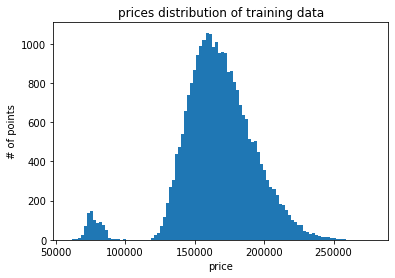

In [4]:
#p_supply_ok
tf_c1,tf_c2=get_gencost(118,mat_gen,mat_gencost)
cost1=tf.math.multiply(real_p*baseMVA, tf_c1)
cost2=tf.math.multiply(K.square(tf.cast(real_p*baseMVA,tf.float32)), tf_c2)
suma = tf.reduce_sum(cost1+cost2,axis=1)
print(min(suma))
plt.hist(suma.numpy(),bins=100)
plt.title('prices distribution of training data')
plt.xlabel('price')
plt.ylabel('# of points')

In [ ]:
min(suma)

<tf.Tensor: shape=(), dtype=float32, numpy=13088.887>

In [ ]:
real_p[0,:]

array([5.60586633e-01, 0.00000000e+00, 0.00000000e+00, 4.95238878e-01,
       0.00000000e+00, 8.10118094e-02, 0.00000000e+00, 8.91937939e-01,
       0.00000000e+00, 1.20965156e+00, 0.00000000e+00, 3.68768545e-01,
       0.00000000e+00, 0.00000000e+00, 3.72576433e-01, 0.00000000e+00,
       0.00000000e+00, 8.59869828e-01, 6.89387213e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.30776700e-01,
       3.01811163e-01, 2.12642410e+00, 2.63286096e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.44331822e-01, 3.79891001e-01,
       0.00000000e+00, 6.87674652e-01, 0.00000000e+00, 1.16480197e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.42690935e-01,
       0.00000000e+00, 1.00235139e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.14558541e-01, 0.00000000e+00, 0.00000000e+00,
       8.81365754e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.78027462e-01, 3.08465542e-01, 1.74528098e-01,
      

In [ ]:
print(tf_c1)
print(tf_c2)

tf.Tensor(
[40.  0.  0. 40.  0. 40.  0. 40.  0. 20.  0. 20.  0.  0. 40.  0.  0. 40.
 40.  0.  0.  0.  0. 40. 20. 20. 40.  0.  0.  0. 20. 40.  0. 40.  0. 40.
  0.  0.  0. 40.  0. 40.  0.  0.  0. 20.  0.  0. 20.  0.  0.  0.  0. 20.
 40. 40.  0.  0. 20.  0. 20. 40.  0.  0. 20. 20.  0.  0. 20. 40.  0. 40.
 40. 40.  0. 40. 40.  0.  0. 20.  0.  0.  0.  0. 40.  0. 20.  0. 20. 40.
 40. 40.  0.  0.  0.  0.  0.  0. 40. 20.  0.  0. 20. 40. 40.  0. 40.  0.
  0. 40. 20. 40. 40.  0.  0. 40.  0.  0.], shape=(118,), dtype=float32)
tf.Tensor(
[0.01       0.         0.         0.01       0.         0.01
 0.         0.01       0.         0.02222222 0.         0.11764706
 0.         0.         0.01       0.         0.         0.01
 0.01       0.         0.         0.         0.         0.01
 0.04545455 0.03184713 0.01       0.         0.         0.
 1.4285715  0.01       0.         0.01       0.         0.01
 0.         0.         0.         0.01       0.         0.01
 0.         0.         0.         0.5

In [5]:
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return K.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

const = ClipConstraint(0.0001)

def define_generator(latent_dim):
  code = keras.Input(shape=(1,1))
  random_noise = keras.Input(shape=(1,latent_dim))
  demand = keras.Input(shape=(1,118*2))
  concat_layer= Concatenate(axis=-1)([code,random_noise, demand])
  hidden = Conv1D(64, (1), activation=None,padding='same')(concat_layer)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  #hidden = Dropout(0.1)(hidden)
  hidden = Conv1D(32, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(16, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(8, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  #hidden = Dropout(0.1)(hidden)
  hidden = layers.Flatten()(hidden)
  g_active = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  g_active = tf.math.multiply(g_active,tf_p_upper)
  g_reactive = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  g_reactive = tf.math.multiply(g_reactive,tf_q_upper-tf_q_lower)\
                                                    +tf_q_lower
  bus_vm = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  bus_vm = tf.math.multiply(bus_vm,tf_vm_upper-tf_vm_lower)+tf_vm_lower
  bus_va = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  bus_va = tf.math.multiply(bus_va,tf_va_upper-tf_va_lower)+tf_va_lower
  g_model = keras.Model(inputs=[code,random_noise,demand], outputs=[g_active,g_reactive,bus_vm,bus_va])
  return g_model

def define_qnetwork():
  g_active = keras.Input(shape=(1,118))
  #cost1 = keras.Input(shape=(118,1))
  #cost2 = keras.Input(shape=(118,1))
  #concat_layer= Concatenate(axis=1)([cost1,cost2])
  hidden = Conv1D(64, (1), activation=None,padding='same')(g_active)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(32, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(8, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(4, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = layers.Flatten()(hidden)
  out_layer = layers.Dense(1,dtype='float32',activation='tanh')(hidden)
  #define model
  q_model = Model(g_active, out_layer)
  #q_model = Model([cost1,cost2], out_layer)
  return q_model

def define_discriminator():
  demand = keras.Input(shape=(1,118*2))
  g_active = keras.Input(shape=(1,118))
  g_reactive = keras.Input(shape=(1,118))
  bus_vm = keras.Input(shape=(1,118))
  bus_va = keras.Input(shape=(1,118))
  concat_layer= Concatenate(axis=-1)([demand,g_active,g_reactive,bus_vm,bus_va])
  hidden = Conv1D(64, (1), activation=None,padding='same',kernel_constraint=const)(concat_layer)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  #hidden = layers.MaxPooling1D(pool_size=(3),padding='same')(hidden)
  hidden = Conv1D(64, (1), activation=None,padding='same',kernel_constraint=const)(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = layers.Flatten()(hidden)
  out_layer = layers.Dense(2,dtype='float32',activation='linear')(hidden)
  #define model
  d_model = Model([demand,g_active,g_reactive,bus_vm,bus_va], out_layer)
  #compile model
  #opt = tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.5)
  #d_model.compile(loss='wasserstein_loss', optimizer=opt, metrics=['accuracy'])
  return d_model

def define_gp_critic():
  demand = keras.Input(shape=(1,118*2))
  g_active = keras.Input(shape=(1,118))
  g_reactive = keras.Input(shape=(1,118))
  bus_vm = keras.Input(shape=(1,118))
  bus_va = keras.Input(shape=(1,118))
  concat_layer= Concatenate(axis=-1)([demand,g_active,g_reactive,bus_vm,bus_va])
  #hidden = Conv1D(64, (3), activation=None,padding='same')(concat_layer)
  #hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  #hidden = layers.MaxPooling1D(pool_size=(3),padding='same')(hidden)
  hidden = Conv1D(128, (1), activation=None,padding='same')(concat_layer)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(32, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(8, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(4, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = layers.Flatten()(hidden)
  out_layer = layers.Dense(2,dtype='float32',activation='linear')(hidden)
  #define model
  d_model = Model([demand,g_active,g_reactive,bus_vm,bus_va], out_layer)
  return d_model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  [g_active,g_reactive,bus_vm,bus_va] = generator.output
  [gen_code, gen_noise, gen_label] = generator.input
  gan_output = d_model([tf.reshape(gen_label,[-1,1,118*2]),tf.reshape(g_active,[-1,1,118]),\
                        tf.reshape(g_reactive,[-1,1,118]),tf.reshape(bus_vm,[-1,1,118]),\
                        tf.reshape(bus_va,[-1,1,118])])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_code, gen_noise, gen_label], gan_output)
  return model

def define_ae(g_model,q_model):
  [g_active,g_reactive,bus_vm,bus_va] = g_model.output
  [gen_code, gen_noise, gen_label] = g_model.input
  #realp_tf = g_active*baseMVA
  #cost1=tf.math.multiply(realp_tf, tf_c1)
  #cost2=tf.math.multiply(K.square(realp_tf), tf_c2)
  q_output = q_model(tf.reshape(g_active,[-1,1,118]))
  ae_model = Model([gen_code, gen_noise, gen_label], q_output)
  return ae_model

def rdm_load_pq_20per(case_pload,case_qload,sample_number):
    number_of_bus = case_pload.shape[0]
    p_demand = np.zeros([sample_number,number_of_bus])
    q_demand = np.zeros([sample_number,number_of_bus])
    for i in range(0,number_of_bus):
        pi = case_pload[i]
        qi = case_qload[i]
        if case_pload[i]!=0:
          p_mw = np.random.uniform(pi*0.8,pi*1.2,sample_number)
          q_mvar = np.random.uniform(qi*0.8,qi*1.2,sample_number)
          p_demand[:,i] = p_mw
          q_demand[:,i] = q_mvar
    return p_demand,q_demand

def wasserstein_loss(y_true, y_pred):
	return K.mean(y_true * y_pred)

def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  code_input = np.random.uniform(-1,1,n_samples).reshape([n_samples,1])
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  p_demand,q_demand = rdm_load_pq_20per(case118_pload,case118_qload,n_samples)
  labels = np.concatenate([p_demand,q_demand],axis=1)
  return [code_input,z_input, labels]

# select real samples
def generate_real_samples(n_samples):
  # choose random instances
  ix = np.random.randint(0, 26495, n_samples)
  # select images and labels
  batch_condition,batch_vm,batch_va,batch_p,batch_q = real_conditions[ix], \
    real_vm[ix], real_va[ix], real_p[ix], real_q[ix]
  # generate class labels
  y = -np.ones((n_samples, 1))
  return batch_condition,batch_vm,batch_va,batch_p,batch_q, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	c_input, z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([c_input, z_input, labels_input])
	# create class labels
	y = np.ones((n_samples, 1))
	return c_input, labels_input,images, y

def feasibility_checking(p_demand,q_demand, active_p,reactive_q,vm,va):
  generated_size = p_demand.shape[0]
  #Step1: calculate power withdraw on each bus
  P_out = tf.convert_to_tensor(p_demand-active_p,dtype='float32')
  Q_out = tf.convert_to_tensor(q_demand-reactive_q,dtype='float32')
  #pdb.set_trace()
  #get voltage on each bus
  v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(va,tf.constant(math.pi/180,dtype='float32'))))
  v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(va,tf.constant(math.pi/180,dtype='float32'))))
  V = tf.reshape(tf.complex(v_r,v_i),[generated_size,118])

  #calculate current
  Y_bus_tf = tf.convert_to_tensor(Y_bus)
  I = tf.matmul(V,Y_bus_tf)

  #calculate power injection on each bus
  S_in = tf.math.multiply(V,tf.math.conj(I))
  P_in = tf.math.real(S_in)
  Q_in = tf.math.imag(S_in)

  #evaluate the balance
  p_balance = tf.reduce_mean(P_in+P_out,axis=0)
  q_balance = tf.reduce_mean(Q_in+Q_out,axis=0)
  return p_balance,q_balance

# use the generator to generate n fake examples, with class labels
def generate_test_samples(generator, latent_dim, test_samples):
  # generate points in latent space
  n_samples = opf_real_conditions_validation.shape[0]
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, opf_real_conditions_validation])
  # create class labels
  y = np.ones((n_samples, 1))
  return opf_real_conditions_validation,images, y

def optimality_checking(p_opt,q_opt,p_fake,q_fake):
  p_mse = K.mean(K.square(p_opt-p_fake))
  q_mse = K.mean(K.square(q_opt-q_fake))
  return p_mse,q_mse

In [6]:
latent_dim = 100
batch_size = 64
half_batch = batch_size//2
# create the discriminator
#discriminator = load_model('/content/drive/MyDrive/Phd/opf_gan/cgan_discriminator.h5',\
 #                          custom_objects={'ClipConstraint': ClipConstraint})
#discriminator=define_discriminator()
discriminator = define_gp_critic()
# create the generator
#generator = load_model('/content/drive/MyDrive/Phd/opf_gan/cgan_generator.h5')
generator =define_generator(latent_dim)
qnetwork = define_qnetwork()
# create the gan
gan_model = define_gan(generator, discriminator)
ae_model = define_ae(generator,qnetwork)
loss_d1_list = []
loss_d2_list = []
loss_g_list = []                                                                              
real_acc_list = []
fake_acc_list = []
dy_dx_list=[]
ae_list=[]
pbalance_list=[]
qbalance_list=[]
opt_perr_list=[]
opt_qerr_list=[]
ae_loss_list=[]
gp_list=[]

In [ ]:
discriminator.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 1, 236)]     0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 1, 118)]     0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 1, 118)]     0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 1, 118)]     0                                            
___________________________________________________________________________________________

In [11]:
iterations = 10000
n_critic=20
best_pb=0.3
best_qb=0.3
for i in range(iterations):
  with tf.GradientTape(persistent=True) as tape:
    discriminator.trainable=True
    #pdb.set_trace()
    #Initializing optimizers:
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    q_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    
    '''
      Block 1 starts: Training the discriminator for $n_critic times
    '''
    for _j in range(n_critic):
      #Prepare real and fake data
      real_batch_demand, real_batch_vm,real_batch_va,real_batch_p,real_batch_q, \
                  real_batch_y = generate_real_samples(half_batch)
      [fake_latent_code, fake_latent_noise, _] = \
                  generate_latent_points(latent_dim, half_batch)
      [fake_batch_p,fake_batch_q,fake_batch_vm,fake_batch_va] = \
                  generator([tf.reshape(fake_latent_code,[-1,1,1]),\
                  tf.reshape(fake_latent_noise,[-1,1,latent_dim]),\
                  tf.reshape(real_batch_demand,[-1,1,118*2])])
      fake_batch_y = np.ones((half_batch, 1))
      alpha = K.random_uniform(
          shape=[half_batch,1], 
          minval=0.,
          maxval=1.
      )
      diff_batch_vm = real_batch_vm - fake_batch_vm
      diff_batch_va = real_batch_va - fake_batch_va
      diff_batch_p = real_batch_p - fake_batch_p
      diff_batch_q = real_batch_q - fake_batch_q

      inter_batch_vm = real_batch_vm + (alpha*diff_batch_vm)
      inter_batch_va = real_batch_va + (alpha*diff_batch_va)
      inter_batch_p = real_batch_p + (alpha*diff_batch_p)
      inter_batch_q = real_batch_q + (alpha*diff_batch_q)

      '''
      Calculate the Cost function for discriminator
      '''
      #Prepare the gradient penalty
      inter_d_output = discriminator([tf.reshape(real_batch_demand,[-1,1,118*2]),\
                                tf.reshape(inter_batch_p,[-1,1,118]),\
                                tf.reshape(inter_batch_q,[-1,1,118]),\
                                tf.reshape(inter_batch_vm,[-1,1,118]),\
                                tf.reshape(inter_batch_va,[-1,1,118])])
      inter_gradients_p = tape.gradient(inter_d_output, [inter_batch_p,inter_batch_q,inter_batch_vm,inter_batch_va])
      rdc_sum = tf.math.reduce_sum(tf.math.reduce_sum(tf.square(inter_gradients_p),axis=0),axis=1)
      slopes = K.sqrt(rdc_sum)
      gradient_penalty = tf.reduce_mean(tf.square((slopes-1.)))
      
      #calculate the regular WGAN loss
      real_d_output = discriminator([tf.reshape(real_batch_demand,[-1,1,118*2]),\
                                            tf.reshape(real_batch_p,[-1,1,118]),\
                                            tf.reshape(real_batch_q,[-1,1,118]),\
                                            tf.reshape(real_batch_vm,[-1,1,118]),\
                                            tf.reshape(real_batch_va,[-1,1,118])])
      fake_d_output = discriminator([tf.reshape(real_batch_demand,[-1,1,118*2]),\
                                            tf.reshape(fake_batch_p,[-1,1,118]),\
                                            tf.reshape(fake_batch_q,[-1,1,118]),\
                                            tf.reshape(fake_batch_vm,[-1,1,118]),\
                                            tf.reshape(fake_batch_va,[-1,1,118])])
      d1_loss = K.mean(real_d_output*real_batch_y)
      loss_d1_list.append(d1_loss.numpy())
      d2_loss = K.mean(fake_d_output*fake_batch_y)
      loss_d2_list.append(d2_loss.numpy())
      gp_list.append(gradient_penalty.numpy())
      d_loss = d1_loss+d2_loss+100*gradient_penalty
      d_grads = tape.gradient(d_loss,discriminator.trainable_weights)
      d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_weights))
    '''
      Block 1 ends.
    '''
    
    '''
      Block 2 starts: Training the generator
    '''
    #Train Generator  
    real_batch_demand,_,_,_,_,_ = generate_real_samples(batch_size)
    [fake_latent_code, fake_latent_noise, _] = \
                  generate_latent_points(latent_dim, batch_size)
    tf_real_batch_demand = tf.keras.backend.variable(real_batch_demand)
    tape.watch(tf_real_batch_demand)
    [fake_batch_p,fake_batch_q,fake_batch_vm,fake_batch_va] = \
                        generator([tf.reshape(fake_latent_code,[-1,1,1]),\
                        tf.reshape(fake_latent_noise,[-1,1,latent_dim]),\
                        tf.reshape(tf_real_batch_demand,[-1,1,118*2])])
    fake_gan_output = discriminator([tf.reshape(real_batch_demand,[-1,1,118*2]),\
                                            tf.reshape(fake_batch_p,[-1,1,118]),\
                                            tf.reshape(fake_batch_q,[-1,1,118]),\
                                            tf.reshape(fake_batch_vm,[-1,1,118]),\
                                            tf.reshape(fake_batch_va,[-1,1,118])])
    fake_batch_y = -np.ones((batch_size, 1))
    gan_loss = K.mean(fake_gan_output*fake_batch_y)
    dy_dx = tf.reduce_mean(tf.square(tape.gradient([fake_batch_p,fake_batch_q,\
                                                    fake_batch_vm,fake_batch_va],\
                                                    tf_real_batch_demand)))
    loss_g_list.append(gan_loss.numpy())
    dy_dx_list.append(dy_dx.numpy())
    discriminator.trainable=False
    gan_grads = tape.gradient(gan_loss+100*dy_dx, gan_model.trainable_weights)
    g_optimizer.apply_gradients(zip(gan_grads, gan_model.trainable_weights))
  
    #Training the Q Inference Network
    for _k in range(10):
      q_output = qnetwork(tf.reshape(fake_batch_p,[-1,1,118]))
      q_loss = 10*K.mean(K.square(fake_latent_code-q_output))
      ae_loss_list.append(q_loss.numpy())
      ae_grads = tape.gradient(q_loss, ae_model.trainable_weights)
      q_optimizer.apply_gradients(zip(ae_grads, ae_model.trainable_weights))
    '''
      Block 2 ends.
    '''

    print('This is the iter '+str(i)+', the d1 loss is: '+str(d1_loss.numpy())+\
          ', the d2 loss is: '+str(d2_loss.numpy())+\
          ', the g loss is: '+str(gan_loss.numpy())+\
          ', the ae loss is: '+str(q_loss.numpy())+\
          ', the jacobian loss is:'+str(dy_dx.numpy()))
  if i%100==0:
    generated_size = 6000
    c_input, z_input, opf_real_conditions_validation = generate_latent_points(latent_dim, generated_size)
    # predict outputs
    #c_input_t, z_input_t, _ = generate_latent_points(latent_dim, real_conditions.shape[0])
    #[fake_p_t,fake_q_t,fake_vm_t,fake_va_t] = generator.predict([c_input_t, z_input_t, real_conditions])
    [fake_p,fake_q,fake_vm,fake_va] = generator.predict([c_input.reshape([-1,1,1]), z_input.reshape([-1,1,latent_dim]),\
                                                         opf_real_conditions_validation.reshape([-1,1,118*2])])
    # create class labels
    y_fake = np.ones((generated_size, 1))
    #pb_training,qb_training=feasibility_checking(real_conditions[:,0:118],real_conditions[:,118:], \
    #                                             fake_p_t,fake_q_t,fake_vm_t,fake_va_t)
    pb,qb=feasibility_checking(opf_real_conditions[:,0:118],opf_real_conditions[:,118:], fake_p,fake_q,fake_vm,fake_va)
    #po,qo=optimality_checking(opf_real_p_validation*baseMVA,opf_real_q_validation*baseMVA,fake_p*baseMVA,fake_q*baseMVA)
    #pb=K.abs(pb)
    #qb=K.abs(qb)
    pbalance_list.append(K.mean(pb).numpy())
    qbalance_list.append(K.mean(qb).numpy())
    #print('training:')
    #print(K.mean(pb_training).numpy())
    #print(K.mean(qb_training).numpy())
    #print('validation:')
    print(K.mean(pb).numpy())
    print(K.mean(qb).numpy())
    if (abs(K.mean(pb).numpy())<best_pb) and (abs(K.mean(qb).numpy())<best_qb):
      best_pb = abs(K.mean(pb).numpy())
      best_qb = abs(K.mean(qb).numpy())
      print('We hit the best performance!, the pb='+str(best_pb)+',qb='+str(best_qb))
      # save the generator model
      generator.save('/content/drive/MyDrive/Phd/opf_gan/118_generator_114c.h5')
      discriminator.save('/content/drive/MyDrive/Phd/opf_gan/118_discriminator_114c.h5')
      qnetwork.save('/content/drive/MyDrive/Phd/opf_gan/118_qnetwork_114c.h5')

Streaming output truncated to the last 5000 lines.
This is the iter 5098, the d1 loss is: 2806.9375, the d2 loss is: -3284.6875, the g loss is: 3200.6797, the ae loss is: 0.006673227, the jacobian loss is:0.11228012
This is the iter 5099, the d1 loss is: 2732.2422, the d2 loss is: -3180.289, the g loss is: 3144.4219, the ae loss is: 0.0061694556, the jacobian loss is:0.089347295
This is the iter 5100, the d1 loss is: 2843.4375, the d2 loss is: -3252.2812, the g loss is: 3278.3828, the ae loss is: 0.009126043, the jacobian loss is:0.109736174
0.18607065
0.6967856
This is the iter 5101, the d1 loss is: 2845.4062, the d2 loss is: -3291.7344, the g loss is: 3212.9375, the ae loss is: 0.008255178, the jacobian loss is:0.10155605
This is the iter 5102, the d1 loss is: 2924.586, the d2 loss is: -3340.7969, the g loss is: 3319.4375, the ae loss is: 0.007240328, the jacobian loss is:0.11440117
This is the iter 5103, the d1 loss is: 2942.75, the d2 loss is: -3369.0156, the g loss is: 3375.2969, 

In [ ]:
aa=tape.gradient([fake_batch_p,fake_batch_q,fake_batch_vm,fake_batch_va],tf_real_batch_demand)

In [ ]:
print(tf_real_batch_demand)

NameError: ignored

In [ ]:
#What I am doing now is to adjust the discriminator, the dimension has problem
discriminator.summary()

NameError: ignored

In [ ]:
K.mean(pb).numpy()

0.818477

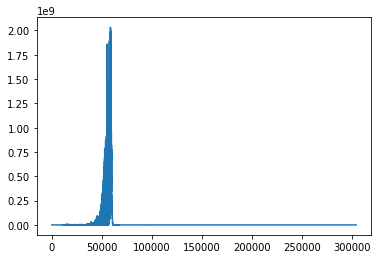

In [26]:
plt.plot(gp_list)
plt.show()

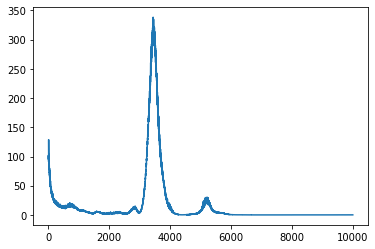

In [27]:
plt.plot(dy_dx_list[:10000])
plt.show()

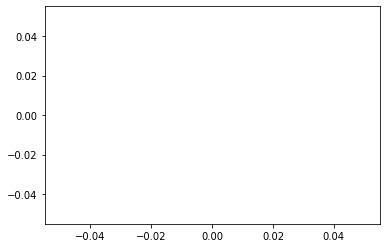

In [24]:
plt.plot(ae_list[:])
plt.show()

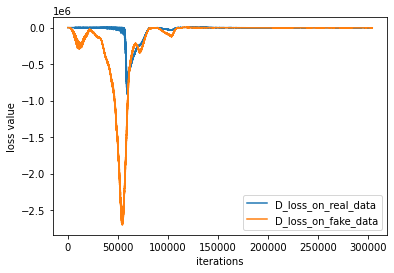

In [28]:
#plt.plot(loss_g_list)
lst = np.array(loss_d1_list)
plt.plot(list(-lst))
plt.plot(loss_d2_list)
plt.legend(['D_loss_on_real_data','D_loss_on_fake_data'])
plt.xlabel('iterations')
plt.ylabel('loss value')
plt.show()

Text(0, 0.5, 'norm value')

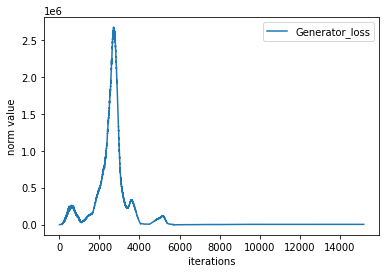

In [29]:
plt.plot(loss_g_list)
plt.legend(['Generator_loss'])
plt.xlabel('iterations')
plt.ylabel('norm value')

In [ ]:
generator.save('/content/drive/MyDrive/Phd/opf_gan/118_generator.h5')
discriminator.save('/content/drive/MyDrive/Phd/opf_gan/118cgan_discriminator.h5')
qnetwork.save('/content/drive/MyDrive/Phd/opf_gan/118cgan_qnetwork.h5')

In [ ]:
K.mean(qb)

<tf.Tensor: shape=(), dtype=float32, numpy=0.08903221>

In [ ]:
K.mean(pb)

<tf.Tensor: shape=(), dtype=float32, numpy=0.025738597>

In [ ]:
pp_list=[]
for p in pbalance_list:
  blc=K.mean(p)
  pp_list.append(blc)
qq_list=[]
for q in qbalance_list:
  blc=K.mean(q)
  qq_list.append(blc)

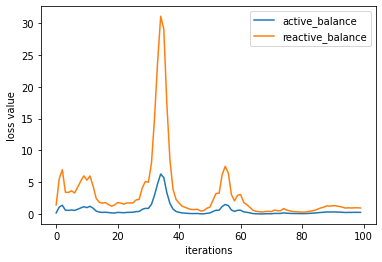

In [30]:
plt.plot(pbalance_list[:100])
plt.plot(qbalance_list[:100])
plt.legend(['active_balance','reactive_balance'])
plt.xlabel('iterations')
plt.ylabel('loss value')
plt.show()

In [31]:
min(qbalance_list[:])

0.27055508

In [ ]:
np.mean(q_balance)

7.993875

In [ ]:
P_out

NameError: ignored

In [ ]:
#def feasibility_verification(Y_bus,vm,va):
Y_bus_tf = tf.convert_to_tensor(Y_bus)
v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(va,tf.constant(math.pi/180,dtype='float32'))))
v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(va,tf.constant(math.pi/180,dtype='float32'))))
V = tf.reshape(tf.complex(v_r,v_i),[batch_size,3,1])
vj_vi = V-tf.reshape(V,[batch_size,1,3])
y_vj_vi = tf.math.multiply(Y_bus_tf,vj_vi)
v_expand = tf.repeat(V,3,axis=2)
s_ij = tf.math.multiply(v_expand,tf.math.conj(y_vj_vi))
S_in = tf.reduce_sum(s_ij,axis=2)
P_in = tf.math.real(S_in)
Q_in = tf.math.imag(S_in)
I = tf.matmul(Y_bus_tf,V)
#S_out = tf.reshape(tf.math.multiply(V,tf.math.conj(I)),[batch_size,3])
#P_out = tf.math.real(S_out)
#Q_out = tf.math.imag(S_out)
P_out = p_bus_tf
Q_out = q_bus_tf

first_constraint = tf.reduce_mean(tf.square(P_in+P_out),axis=0)
second_constraint = tf.reduce_mean(tf.square(Q_in+Q_out),axis=0)
#return p_balance,q_balance

In [ ]:
vm_gen_fake6=np.zeros([generated_size,5])
vm_gen_fake6[:,0] = fake_vm[:,1]
vm_gen_fake6[:,1] = fake_vm[:,21]
vm_gen_fake6[:,2] = fake_vm[:,26]
vm_gen_fake6[:,3] = fake_vm[:,22]
vm_gen_fake6[:,4] = fake_vm[:,12]

fake_p_6 = np.zeros([generated_size,6])
fake_p_6[:,1] = fake_p[:,1]
fake_p_6[:,2] = fake_p[:,21]
fake_p_6[:,3] = fake_p[:,26]
fake_p_6[:,4] = fake_p[:,22]
fake_p_6[:,5] = fake_p[:,12]

In [ ]:
pd.DataFrame(fake_demand[:,0:30]).to_csv('p_demand_test.csv')
pd.DataFrame(fake_demand[:,30:]).to_csv('q_demand_test.csv')
pd.DataFrame(fake_p_6).to_csv('p_supply_test.csv')
pd.DataFrame(vm_gen_fake6).to_csv('vm_gen_test.csv')

In [ ]:
np.sum(fake_demand[:,0:30])

1.9265641222201484

In [ ]:
fake_p

array([[0.49755725, 0.5038785 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.1830803 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.29379764, 0.0864872 , 0.        , 0.        ,
        0.        , 0.3854256 , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [ ]:
fake_q

array([[0.07549758, 0.15891723, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.2660091 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.5072156 , 0.15104723, 0.        , 0.        ,
        0.        , 0.2731502 , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [ ]:
opf_real_conditions_validation[0,:]

array([0.        , 0.2247287 , 0.02861889, 0.06342201, 0.        ,
       0.        , 0.20798738, 0.24388678, 0.        , 0.05189385,
       0.        , 0.09081932, 0.        , 0.07285945, 0.06689444,
       0.03501143, 0.10266188, 0.02595863, 0.09509666, 0.02374388,
       0.17385561, 0.        , 0.03296214, 0.09885429, 0.        ,
       0.02855109, 0.        , 0.        , 0.02501366, 0.08579894,
       0.        , 0.10438835, 0.01160139, 0.01670866, 0.        ,
       0.        , 0.10647208, 0.2823335 , 0.        , 0.01905765,
       0.        , 0.08904267, 0.        , 0.01729766, 0.02900119,
       0.01551684, 0.05661812, 0.0078438 , 0.03360168, 0.00786441,
       0.09881533, 0.        , 0.01308805, 0.06942913, 0.        ,
       0.01911108, 0.        , 0.        , 0.0105829 , 0.01575471])

In [ ]:
sample_result = np.zeros([1000,30])
# generate points in latent space
#n_samples = opf_real_conditions_validation.shape[0]
for ii in range(0,1000):
  z_input, labels_input = generate_latent_points(100, 2)
  # predict outputs
  images = generator.predict([z_input, opf_real_conditions_validation[0:2,:]])
  sample_result[ii,:]=images[0][0,:]
  print(ii)

In [ ]:
generator.save('/content/drive/MyDrive/Phd/opf_gan/gen_118_113c.h5')
discriminator.save('/content/drive/MyDrive/Phd/opf_gan/dis_118_113c.h5')
qnetwork.save('/content/drive/MyDrive/Phd/opf_gan/q_118_113c.h5')